### Installing requirements

In [1]:
!pip install -q --upgrade \
    transformers \
    accelerate \
    bitsandbytes \
    requests \
    pillow \
    matplotlib \
    peft
!pip install -q \
    "torch==2.6.0" \
    torchvision \
    fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 89.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 22.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 85.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 109.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Model loading

In [2]:
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import torch

2025-05-26 20:47:13.483866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748292433.670708      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748292433.721391      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
model_name = "OpenGVLab/InternVL2_5-4B"
adapter_name = "H1merka/InternVL2_5-4B-QLoRA-RussianSummarization"

In [4]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(adapter_name, trust_remote_code=True)

base_model = AutoModel.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quantization_config,
    trust_remote_code=True
)

# LoRA adapter only for LLM
base_model.language_model = PeftModel.from_pretrained(
    base_model.language_model,
    adapter_name
)

# Full model to eval()
model = base_model.eval()

tokenizer_config.json:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

configuration_internvl_chat.py:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

configuration_intern_vit.py:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-4B:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-4B:
- configuration_internvl_chat.py
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_internvl_chat.py:   0%|          | 0.00/15.9k [00:00<?, ?B/s]

conversation.py:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-4B:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_intern_vit.py:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-4B:
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-4B:
- modeling_internvl_chat.py
- conversation.py
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


FlashAttention2 is not installed.


model.safetensors.index.json:   0%|          | 0.00/71.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.43G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/2.54G [00:00<?, ?B/s]

### Initialization of functions for preprocessing

In [5]:
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
from PIL import Image

In [6]:
# ImageNet Normalization
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

In [7]:
def build_transform(input_size=448):
    '''Pipeline for transformation'''
    return T.Compose([
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

In [8]:
def preprocess_image(image: Image.Image, image_size=448):
    '''Image transformation'''
    image = image.convert('RGB')
    transform = build_transform(image_size)
    pixel_values = transform(image).unsqueeze(0)
    return pixel_values

### Inference

In [9]:
import requests
import matplotlib.pyplot as plt

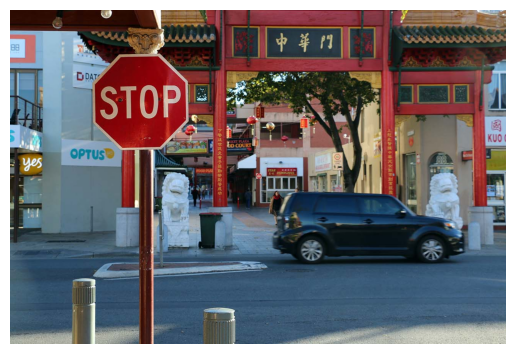

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Question:
[IMAGE]
Пожалуйста, опиши визуальное содержание изображения, и предоставь короткий текст, который связывает изображение с следующим текстом: 'городская жизнь в Пекине'.
Answer:
................................................................................................................................


In [10]:
image_url = "https://www.ilankelman.org/stopsigns/australia.jpg"
generation_config = dict(max_new_tokens=128, do_sample=False, eos_token_id=tokenizer.eos_token_id)

# Image loading
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')

# Image display
plt.imshow(image)
plt.axis('off')
plt.show()

# Preprocessing
pixel_values = preprocess_image(image).to(dtype=torch.float16, device=model.device)

# Text input to model
additional_text = "городская жизнь в Пекине"

# Prompt
question = (
    "<image>\n"
    "Пожалуйста, опиши визуальное содержание изображения, "
    "и предоставь короткий текст, который связывает изображение с "
    f"следующим текстом: '{additional_text}'."
)

# Model inference
response = model.chat(tokenizer, pixel_values, question, generation_config)

print("Question:\n" + question.replace('<image>', '[IMAGE]'))
print("Answer:\n" + response)